In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display as disp
import seaborn as sns
from scipy import signal
from scipy.signal import lfilter
import scipy

sns.set_style('darkgrid')

Text(0.5, 1.0, 'The input frame EGG')

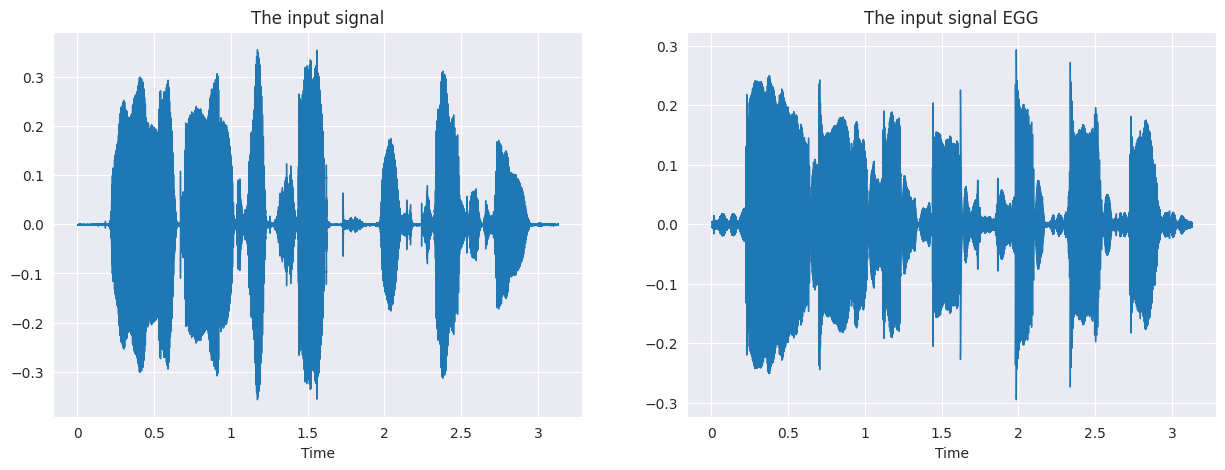

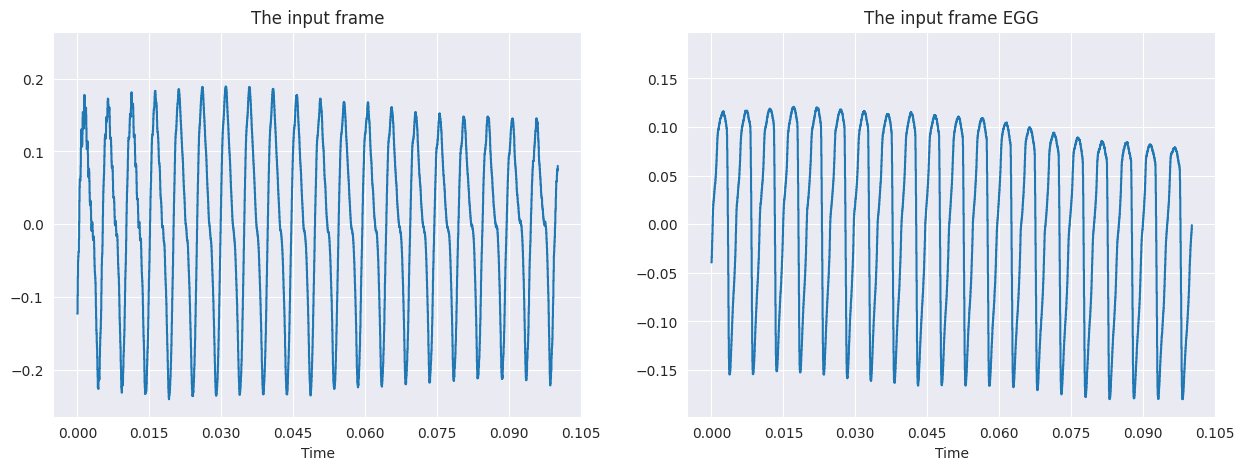

In [2]:
[sound,egg],fs = librosa.load('wav/arctic_b0539.wav',mono = False)

plt.figure(figsize=(15,5))
sns.set_style("darkgrid")
plt.subplot(121)
disp.waveshow(sound) 
plt.title("The input signal")
plt.subplot(122)
disp.waveshow(egg)
plt.title("The input signal EGG" )

sound = sound[221*75:221*85]
egg = egg[221*75:221*85]

plt.figure(figsize=(15,5))
sns.set_style("darkgrid")
plt.subplot(121)
disp.waveshow(sound) 
plt.title("The input frame")
plt.subplot(122)
disp.waveshow(egg)
plt.title("The input frame EGG" )


Text(0, 0.5, 'Amplitude')

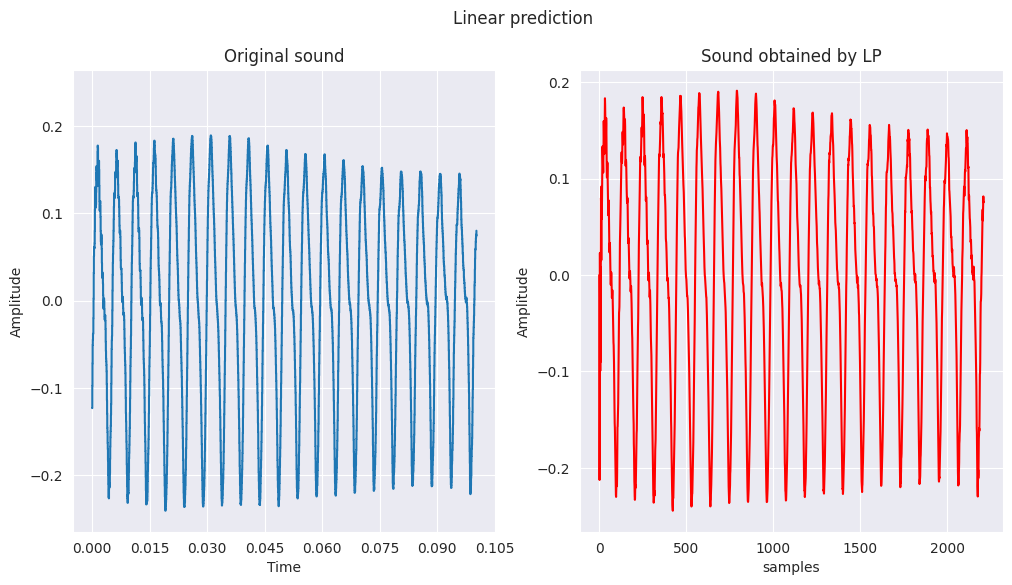

In [3]:
# LPC Spectrum 

lpc_coeff = librosa.lpc(sound, order=13)
lpc_coeff = -1 * np.array(lpc_coeff[1:])

arr = np.hstack([0, lpc_coeff])
sound_LP = scipy.signal.lfilter(arr, 1, sound)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.suptitle('Linear prediction')
disp.waveshow(sound)
plt.title('Original sound')
plt.ylabel("Amplitude")


plt.subplot(1,2,2)
plt.plot(sound_LP, color='red') 
plt.title("Sound obtained by LP")
plt.xlabel("samples")
plt.ylabel("Amplitude")

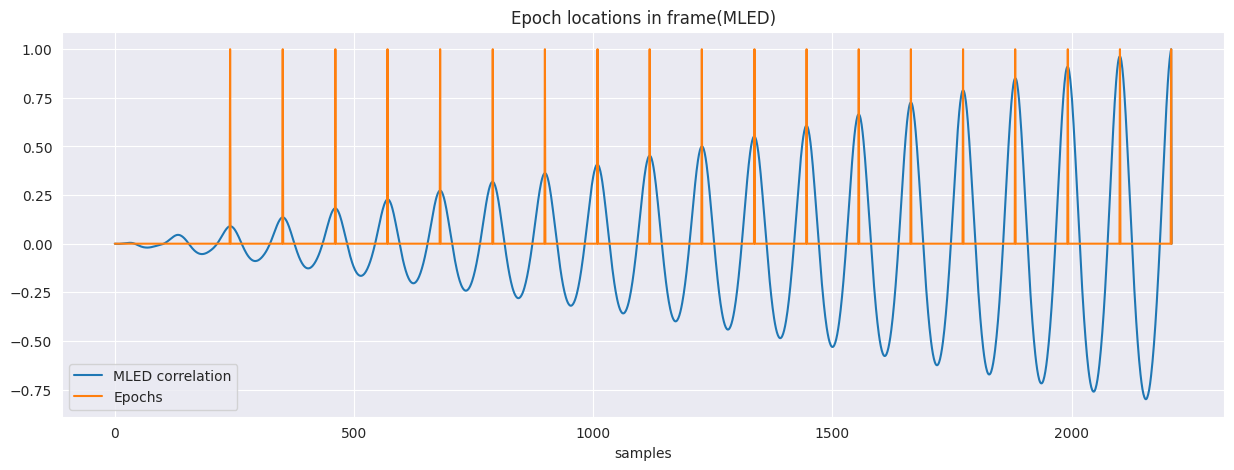

In [4]:
epoch = np.zeros(len(sound_LP))
sound_pad = np.pad(sound,len(sound_LP))
for it in range(len(sound_LP)-1):
    sum = 0
    for n in range(len(sound_LP)-1):
        sum += sound_LP[n]*sound_pad[n+it]
    epoch[it] = sum

epoch = epoch/max(abs(epoch))
epoch_peaks,_ = scipy.signal.find_peaks(epoch,height=.05)
epoch_mled = np.zeros(len(epoch))   
epoch_mled[epoch_peaks] = 1


plt.figure(figsize=(15,5))
plt.plot(epoch)
plt.plot(epoch_mled)
plt.title("Epoch locations in frame(MLED)")
plt.xlabel("samples")
plt.legend(["MLED correlation","Epochs"])    


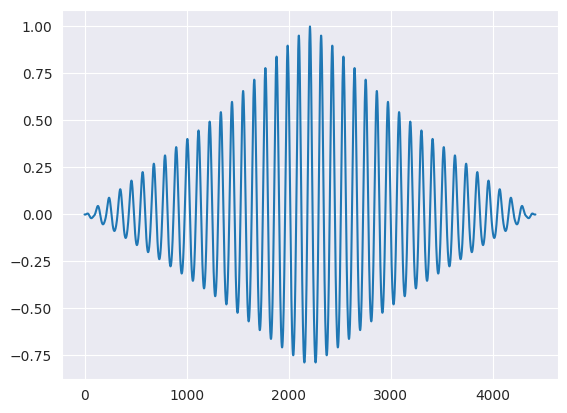

In [5]:
out = np.correlate(sound_LP,sound_LP,mode='full')
out = out/max(abs(out))
plt.plot(out)

In [6]:
##differncing the egg signal
egg_diff = np.diff(egg)

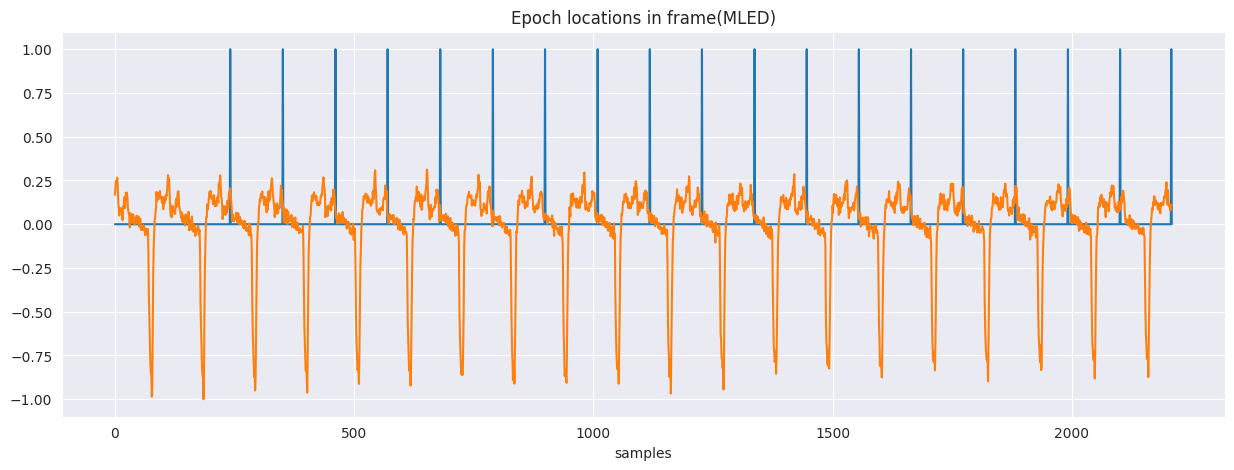

In [7]:
plt.figure(figsize=(15,5))
plt.plot(epoch_mled)
plt.title("Epoch locations in frame(MLED)")
plt.xlabel("samples")

egg_diff = egg_diff/np.max(abs(egg_diff))
plt.plot(egg_diff)

## Metrics

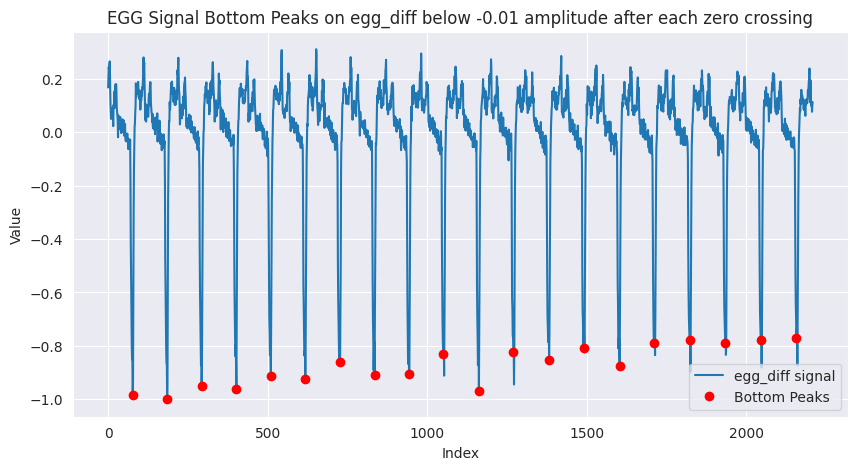

In [8]:
from scipy.signal import find_peaks

# Find zero crossings in the EGG signal
zero_crossings = np.where(np.diff(np.sign(egg)))[0]

# Find bottom peaks below -0.01 amplitude after each zero crossing
bottom_peaks = []
for crossing in zero_crossings:
    # Find peaks in the segment after each zero crossing
    segment = egg_diff[crossing:]
    neg_segment = -segment
    peaks, _ = find_peaks(neg_segment, height=-0.06)

    if len(peaks) > 0:
        # Consider only the first peak after the zero crossing
        bottom_peak_index = peaks[0] + crossing
        if egg_diff[bottom_peak_index] < 0:  # Check if the bottom peak is below 0
            bottom_peaks.append(bottom_peak_index)

# Plot the EGG signal and mark the bottom peaks
plt.figure(figsize=(10, 5))
plt.plot(egg_diff, label='egg_diff signal')
plt.plot(bottom_peaks, egg_diff[bottom_peaks], 'ro', label='Bottom Peaks')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('EGG Signal Bottom Peaks on egg_diff below -0.01 amplitude after each zero crossing')
plt.show()


In [9]:
# Find epochs in 'egg' signal
egg_epochs = []
for i in range(len(egg) - 1):
    if egg[i] * egg[i + 1] < 0 and egg[i + 1] > 0:
        egg_epochs.append(i)

# Comparing the number of epochs detected
num_sound_epochs = len(epoch_peaks)
num_egg_epochs = len(bottom_peaks)
print(f"Number of epochs detected in 'sound': {num_sound_epochs}")
print(f"Number of epochs detected in 'egg' signal: {num_egg_epochs}")


Number of epochs detected in 'sound': 19
Number of epochs detected in 'egg' signal: 20


In [10]:
from tabulate import tabulate

# Assuming you have already calculated 'epoch' and 'epoch_peaks'

# Calculate the distances between individual epochs in milliseconds
epoch_distances = []
for epoch_index in epoch_peaks:
    closest_eggs = [abs(epoch_index - egg_index) for egg_index in bottom_peaks]
    epoch_distances.append(min(closest_eggs))

# Convert sample indices to milliseconds
ms_per_sample = 1000 / fs  # Calculate the duration of a single sample in milliseconds

# Individual distances between epochs and EGG in milliseconds
epoch_distances_ms = [distance * ms_per_sample for distance in epoch_distances]

# Calculate the average distance between epochs
avg_epoch_distance = np.mean(epoch_distances_ms)

total_distance = 0
count = 0
table_data = []


for idx, distance in enumerate(epoch_distances_ms ):
    table_data.append([f"Epoch {idx + 1}", f"{ (distance - 1.53) :.2f} ms"])
    total_distance += distance - 1.53
    count += 1

# Average Identification Error
avg_identification_error = total_distance / count

# Identification Accuracy (IDA = standard deviation of identification errors)
identification_errors = [abs(epoch_index - min(bottom_peaks, key=lambda x: abs(epoch_index - x))) for epoch_index in epoch_peaks]
identification_accuracy = np.std(identification_errors)

# Printing the table using tabulate
print(tabulate(table_data, headers=["Epoch", "Distance to EGG"], tablefmt="pretty"))

print(f"\nAverage Identification Error: {avg_identification_error} ms")

# print(f"\nStandard Deviation of Identification Errors (IDA): {identification_accuracy}")


+----------+-----------------+
|  Epoch   | Distance to EGG |
+----------+-----------------+
| Epoch 1  |     0.83 ms     |
| Epoch 2  |     0.78 ms     |
| Epoch 3  |     0.69 ms     |
| Epoch 4  |     0.65 ms     |
| Epoch 5  |     0.56 ms     |
| Epoch 6  |     0.51 ms     |
| Epoch 7  |     0.51 ms     |
| Epoch 8  |     0.37 ms     |
| Epoch 9  |     0.47 ms     |
| Epoch 10 |     0.42 ms     |
| Epoch 11 |     0.51 ms     |
| Epoch 12 |     0.47 ms     |
| Epoch 13 |     0.65 ms     |
| Epoch 14 |     0.65 ms     |
| Epoch 15 |     0.74 ms     |
| Epoch 16 |     0.83 ms     |
| Epoch 17 |     0.92 ms     |
| Epoch 18 |     0.96 ms     |
| Epoch 19 |     0.78 ms     |
+----------+-----------------+

Average Identification Error: 0.6468707482993196 ms
